Для отработки навыков работы с python и с временными рядами.

Тестирование стратегии торговли - пробой первого часа.
Ждем закрытия первых двух свечек дня.
Если вторая свеча закрылась выше первой - покупаем.
Если вторая свеча закрылась ниже первой - продаем.
В других случаях - ничего не делаем.
Закрываем открытую позицию в конце дня.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('SBER_hour_2020.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925 entries, 0 to 2924
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   <TICKER>  2925 non-null   object 
 1   <PER>     2925 non-null   int64  
 2   <DATE>    2925 non-null   int64  
 3   <TIME>    2925 non-null   int64  
 4   <OPEN>    2925 non-null   float64
 5   <HIGH>    2925 non-null   float64
 6   <LOW>     2925 non-null   float64
 7   <CLOSE>   2925 non-null   float64
 8   <VOL>     2925 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 205.8+ KB


In [4]:
df.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,SBER,60,20200103,110000,255.97,256.97,255.52,255.77,4651320
1,SBER,60,20200103,120000,255.78,257.05,255.52,257.01,3754140
2,SBER,60,20200103,130000,257.00,258.19,256.77,257.20,4061070
3,SBER,60,20200103,140000,257.20,257.60,256.06,256.45,3052930
4,SBER,60,20200103,150000,256.45,256.75,254.56,254.65,5143900


In [5]:
#начальный депозит
start_depo = 10000
#депозит
depo = start_depo
#кол-во для покупки
amount = 0
#цена открытия сделки
trade = 0
#депозит с накоплением
depo_accum = [depo]
#счетчики операций
count_buy = 0
count_sell = 0
#счетчики положительных операций
count_buy_positive = 0
count_sell_positive = 0
operation = 'none'

#словарь для хранения записей для переноса в файл excel
journal = {'Дата':[],'Операция':[], 'Цена открытия':[], 'Кол-во':[], 
           'Цена закрытия':[], 'Результат':[], 'Депозит':[]} 


#функция для открытия позиции
def operation_open(operation):
    global amount, trade
    trade = df['<CLOSE>'][index]                                  
    amount = depo // trade
    print (operation, ', кол-во:', amount, ' шт по ', trade)

    
#функция для закрытия позиции    
def operation_close(operation):
    global depo, amount, trade, depo_accum, count_buy_positive, count_sell_positive
    #результат сделки
    result = 0
    if operation == 'buy':
        result = (df['<CLOSE>'][index] - trade)*amount
        if result>0:
            count_buy_positive += 1 
    if operation == 'sell':
        result = (trade - df['<CLOSE>'][index])*amount
        if result>0:
            count_sell_positive += 1
    depo = depo + result
    depo_accum.append(depo)
    print ('Операция', operation,
           'Закрылся по:', df['<CLOSE>'][index], 
           'Результат сделки:', round(result,2), 
           'Депозит:', round(depo,))
    journal['Дата'].append(df['<DATE>'][index])
    journal['Операция'].append(operation)
    journal['Цена открытия'].append(trade)
    journal['Кол-во'].append(amount)
    journal['Цена закрытия'].append(df['<CLOSE>'][index])
    journal['Результат'].append(result)
    journal['Депозит'].append(depo)
    

#проходим циклом по датафрейму
for index in df.index:
    
    if df['<TIME>'][index]==110000:                                           #первая свеча (закрытие в 11ч)
        op = df['<OPEN>'][index]                                              #цена открытия 
        cl = df['<CLOSE>'][index]                                             #цена закрытия 
        print(df['<DATE>'][index], ', открытие: ', op, ', закрытие: ', cl)
        if cl>op:                                                             #закрытие выше открытия, значит свеча белая
            print('первая свеча белая')
        else:
            print('первая свеча черная')
       
    if df['<TIME>'][index] in range(130000, 230000, 10000):                  #эти свечи пропускаем
        pass    
    
    
    if df['<TIME>'][index]==120000:                                           #вторая свеча (закрытие в 12ч)  
        if (df['<CLOSE>'][index]>cl and cl>op) or (df['<CLOSE>'][index]>op and op>cl):                                        
            operation = 'buy'
            count_buy += 1
            operation_open(operation)
        elif (df['<CLOSE>'][index]<cl and op>cl) or (df['<CLOSE>'][index]<op and cl>op): 
            operation = 'sell'
            count_sell += 1
            operation_open(operation)      
        else:
            operation = 'none'
   
 
    if df['<TIME>'][index]==190000 and (operation=='buy' or operation=='sell'):   #свеча 19ч, пора закрывать если есть открытая позиция
        operation_close(operation)


20200103 , открытие:  255.97 , закрытие:  255.77
первая свеча черная
buy , кол-во: 38.0  шт по  257.01
Операция buy Закрылся по: 255.0 Результат сделки: -76.38 Депозит: 9924
20200106 , открытие:  254.75 , закрытие:  252.1
первая свеча черная
sell , кол-во: 39.0  шт по  252.05
Операция sell Закрылся по: 253.9 Результат сделки: -72.15 Депозит: 9851
20200108 , открытие:  253.62 , закрытие:  255.06
первая свеча белая
buy , кол-во: 38.0  шт по  256.28
Операция buy Закрылся по: 259.15 Результат сделки: 109.06 Депозит: 9961
20200109 , открытие:  259.41 , закрытие:  261.1
первая свеча белая
sell , кол-во: 38.0  шт по  258.97
Операция sell Закрылся по: 257.99 Результат сделки: 37.24 Депозит: 9998
20200110 , открытие:  257.91 , закрытие:  257.45
первая свеча черная
buy , кол-во: 38.0  шт по  258.87
Операция buy Закрылся по: 258.19 Результат сделки: -25.84 Депозит: 9972
20200113 , открытие:  258.21 , закрытие:  258.87
первая свеча белая
20200114 , открытие:  262.58 , закрытие:  261.92
первая свеч

20200831 , открытие:  227.02 , закрытие:  227.63
первая свеча белая
buy , кол-во: 52.0  шт по  229.1
Операция buy Закрылся по: 225.0 Результат сделки: -213.2 Депозит: 11785
20200901 , открытие:  226.71 , закрытие:  227.67
первая свеча белая
sell , кол-во: 52.0  шт по  226.36
Операция sell Закрылся по: 226.72 Результат сделки: -18.72 Депозит: 11767
20200902 , открытие:  228.56 , закрытие:  227.37
первая свеча черная
20200903 , открытие:  221.7 , закрытие:  223.4
первая свеча белая
20200904 , открытие:  218.01 , закрытие:  219.61
первая свеча белая
buy , кол-во: 53.0  шт по  220.02
Операция buy Закрылся по: 220.0 Результат сделки: -1.06 Депозит: 11766
20200907 , открытие:  221.58 , закрытие:  223.04
первая свеча белая
buy , кол-во: 52.0  шт по  223.07
Операция buy Закрылся по: 220.5 Результат сделки: -133.64 Депозит: 11632
20200908 , открытие:  222.01 , закрытие:  220.28
первая свеча черная
sell , кол-во: 53.0  шт по  219.27
Операция sell Закрылся по: 217.25 Результат сделки: 107.06 Депо

In [6]:
df_journal=pd.DataFrame(journal)

In [7]:
df_journal.to_excel("journal_first_hour.xlsx")

In [8]:
#результаты работы стратегии пробоя первого часа

#продолжительность стратегии в днях
period = int((pd.to_datetime(df['<DATE>'][-1:],format='%Y%m%d')  - pd.to_datetime(df['<DATE>'][0],format='%Y%m%d')).dt.days)
#доходность стратегии в %% годовых
profitability = round( (depo-start_depo)/start_depo*100/int(period)*365, 2)

print (' Результат стратегии пробой', 
       '\n Начальный депозит: ', start_depo,
       '\n Депозит: ', round(depo),
       '\n Профит: ', round(depo-start_depo),
       '\n Кол-во операций buy: ', count_buy, ', из них положительных: ', 
       count_buy_positive, '(', round(count_buy_positive/count_buy*100, 1)  ,'%)'
       '\n Кол-во операций sell:', count_sell, ', из них положительных: ',
       count_sell_positive, '(', round(count_sell_positive/count_sell*100, 1)  ,'%)'
       '\n Продолжительность работы по стратегии: ', period, 'дней',
       '\n Доходность стратегии: ', profitability, '% годовых'
      
      )

 Результат стратегии пробой 
 Начальный депозит:  10000 
 Депозит:  11517 
 Профит:  1517 
 Кол-во операций buy:  86 , из них положительных:  48 ( 55.8 %)
 Кол-во операций sell: 91 , из них положительных:  40 ( 44.0 %)
 Продолжительность работы по стратегии:  363 дней 
 Доходность стратегии:  15.26 % годовых


<function matplotlib.pyplot.show(close=None, block=None)>

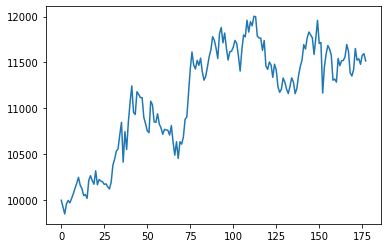

In [9]:
#Кривая депозита
plt.plot(depo_accum)
plt.show

In [10]:
#сколько принесла бы стратегия bue_and_hold 
start = df['<OPEN>'][0] 
finish = df['<OPEN>'][len(df)-1]
amount_bue_and_hold = start_depo // start
bue_and_hold = (finish - start) * amount_bue_and_hold
#доходность bue_and_hold в %% годовых
profitability_bue_and_hold = round( (bue_and_hold)/start_depo*100/int(period)*365, 2)

print ('Результат bue_and_hold:', round(bue_and_hold), 'Количество: ', amount_bue_and_hold, 'шт.'
      'Доходность: ', profitability_bue_and_hold, '% годовых'
      )


Результат bue_and_hold: 601 Количество:  39.0 шт.Доходность:  6.04 % годовых


<function matplotlib.pyplot.show(close=None, block=None)>

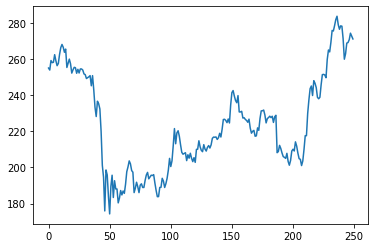

In [11]:
#График по ценам закрытия в 19 ч.
g=[]
for i in df.index:
    if df['<TIME>'][i]==190000:        
        g.append(df['<CLOSE>'][i])
plt.plot(g)
plt.show   